In [73]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score

London bike sharing dataset
========

The data from cycling dataset is grouped by "Start time", this represent the count of new bike shares grouped by hour. The long duration shares are not taken in the count.

Metadata:
---

"timestamp" - timestamp field for grouping the data  
"cnt" - the count of a new bike shares  
"t1" - real temperature in C  
"t2" - temperature in C "feels like"  
"hum" - humidity in percentage  
"wind_speed" - wind speed in km/h  
"weather_code" - category of the weather  
"is_holiday" - boolean field - 1 holiday / 0 non holiday  
"is_weekend" - boolean field - 1 if the day is weekend  
"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.  

"weather_code" category description:  
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity  
2 = scattered clouds / few clouds  
3 = Broken clouds  
4 = Cloudy  
7 = Rain/ light Rain shower/ Light rain  
10 = rain with thunderstorm  
26 = snowfall  
94 = Freezing Fog  

In [39]:
# import data
bikeshare_data = pd.read_csv("data/london_merged_hour.csv")

# reformat timestamp
bikeshare_data['timestamp'] = pd.to_datetime(bikeshare_data['timestamp'])

# create new columns for date and time data
bikeshare_data['date'] = bikeshare_data['timestamp'].dt.normalize()
bikeshare_data['day_of_week'] = bikeshare_data['timestamp'].dt.dayofweek
bikeshare_data['hour'] = bikeshare_data['timestamp'].dt.hour

# rename columns
bikeshare_data = bikeshare_data.rename(columns={
    'cnt': 'count',
    't1': 'temperature_actual',
    't2': 'temperature_feels_like',
    'hum': 'humidity',
    'weather_code': 'weather_condition_code',
    'wind_speed': 'wind_speed',
    'is_holiday': 'is_holiday',
    'is_weekend': 'is_weekend',
    'season': 'season',
    'date': 'date'
})

# weather code
weather_code_map = {
    1:  "Clear or Fog",
    2:  "Few Clouds",
    3:  "Broken Clouds",
    4:  "Cloudy",
    7:  "Light Rain",
    10: "Thunderstorm with Rain",
    26: "Snowfall",
    94: "Freezing Fog"
}

# include weather description for each entry
bikeshare_data['weather_description'] = bikeshare_data['weather_condition_code'].map(weather_code_map)


<Figure size 640x480 with 0 Axes>

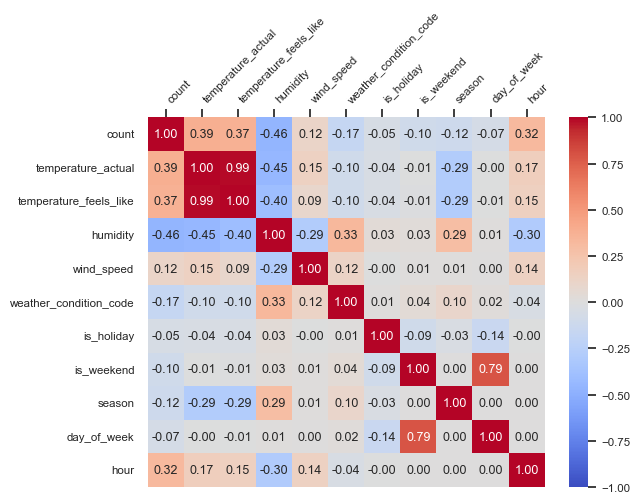

<Figure size 640x480 with 0 Axes>

In [48]:
sns.set_theme(font_scale=.75)
sns.color_palette("coolwarm", as_cmap=True)
hm = sns.heatmap(data=bikeshare_data.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, center=0, cmap=sns.color_palette("coolwarm", as_cmap=True), fmt='.2f')

hm.xaxis.set_ticks_position('top')
hm.xaxis.set_label_position('top')  # optional: move x-axis label too
plt.xticks(rotation=45, ha='left')  # rotate for better readability
plt.yticks(rotation=0)   # keep y labels horizontal

plt.figure()

In [64]:
# create training and test sets
X_train, X_test = train_test_split(bikeshare_data, test_size=0.20)

# run a simple linear regression model using temp_actual as the predictor
model = smf.ols(formula='count ~ temperature_actual', data=X_train)

model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     2408.
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:07:25   Log-Likelihood:            -1.1609e+05
No. Observations:               13931   AIC:                         2.322e+05
Df Residuals:                   13929   BIC:                         2.322e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            217.7690     20

In [63]:
# run a multilinear regression model using multiple features
model_multi = smf.ols(formula='count ~ temperature_actual + humidity + hour', data=X_train)

model_multi = model_multi.fit()
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     1875.
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:07:21   Log-Likelihood:            -1.1472e+05
No. Observations:               13931   AIC:                         2.294e+05
Df Residuals:                   13927   BIC:                         2.295e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1919.7876     60

In [ ]:
# random forest model
bikeshare_data_model = bikeshare_data.drop(columns=['timestamp', 'date', 'weather_description'])

# setup the features and target
X = bikeshare_data_model.drop(columns=['count'])
y = bikeshare_data_model['count']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets